In [1]:
!wget 'https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz'

--2022-04-20 12:40:40--  https://evp-ml-data.s3.us-east-2.amazonaws.com/ml-interview/openimages-personcar/trainval.tar.gz
Resolving evp-ml-data.s3.us-east-2.amazonaws.com (evp-ml-data.s3.us-east-2.amazonaws.com)... 52.219.105.234
Connecting to evp-ml-data.s3.us-east-2.amazonaws.com (evp-ml-data.s3.us-east-2.amazonaws.com)|52.219.105.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 734266940 (700M) [application/x-gzip]
Saving to: ‘trainval.tar.gz’

trainval.tar.gz     100%[===================>] 700.25M  96.9MB/s    in 7.8s    

2022-04-20 12:40:48 (89.8 MB/s) - ‘trainval.tar.gz’ saved [734266940/734266940]



In [2]:
import tarfile
file = tarfile.open('/content/trainval.tar.gz')

In [3]:
file.extractall('/content/Data')

In [4]:
from sklearn.model_selection import train_test_split
import tensorflow as tfa
import pandas as pd
import numpy as np
import shutil
import json
import os
import cv2

class InputPipeline:
    def __init__(self,input_file
                 ,width=1024.0
                 ,height=1024.0):
      """
      Class to convert format of input images and
      bounding boxes to the one supported by YOLOv5.
      """
      self.file = input_file
      self.width = width
      self.height = height
      self._main()

    def _load_json(self):      
      """
      Loading the json file for images and bboxes.
      """
      annotate = open(self.file)
      annotation_file = json.load(annotate)
      return annotation_file
    
    def _extract_column(self):
      """
      Extract relevant fields from images and annotations
      """
      annotation_file = self._load_json()
      images = pd.json_normalize(annotation_file['images'])
      boxes = pd.json_normalize(annotation_file['annotations'])
      return images, boxes
    
    def _clean_data(self):
      """
  	  Dropping irrelevant columns from images and bounding box dataframes
      """
      images, boxes = self._extract_column()
      images.drop('license',axis=1,inplace=True)
      boxes.drop(['segmentation','license','id','area','iscrowd']
                       ,axis=1,inplace=True)
      images.rename(columns = {'id':'image_id'}, inplace = True)
      return images, boxes
      
    def _merge_data(self):
      """
      Consolidating image and bounding box dataframes, grouping by image_id field
      """
      images, boxes = self._clean_data()
      boxes = boxes.groupby('image_id').\
            aggregate(lambda tdf: tdf.tolist())
      final_data = pd.merge(images,boxes,on="image_id")
      return final_data
    
    def _spliting_data(self):
      """
      Splitting data to train and validation subsets
      """
      final_data = self._merge_data()
      train_data, test_data = train_test_split(final_data,test_size=0.1,
                                         shuffle=True)
      train_data.reset_index(drop=True,inplace=True)
      test_data.reset_index(drop=True,inplace=True)
      return train_data, test_data

    @staticmethod
    def convert_format_xywh(out):
      """
      Convert bounding box coordinates 
      (x_upperLeft, y_upperLeft, x_bottomRight, y_bottomRight)
      to the format supported by YOLOv5:
      (x_center, y_center, width, height)
      """
      return np.stack([
        (out[...,0]+out[...,2])/2.0,
        (out[...,1]+out[...,3])/2.0,
        out[...,2]-out[...,0],
        out[...,3]-out[...,1]],axis=-1)
       
    def _transform(self,data):
      """
      Rescale bounding boxes to (1024, 1024)
      and convert bounding boxes to their relative values
      """
      for id,bboxes in enumerate(data.bbox):
        for idx,box in enumerate(bboxes):
          box.insert(0,(data["category_id"][id][idx]-1))
          box[3] = box[3]+box[1]
          box[4] = box[4]+box[2]
          box[1] = (box[1]*self.width)/data.width[id]
          box[2] = (box[2]*self.height)/data.height[id]
          box[3] = (box[3]*self.width)/data.width[id]
          box[4] = (box[4]*self.height)/data.height[id]
          box[1:] = self.convert_format_xywh(np.array(box[1:]))
          box[1] = box[1]/self.width
          box[2] = box[2]/self.height
          box[3] = box[3]/self.width
          box[4] = box[4]/self.height
    
    def _creating_data(self):
      """
      Apply all functions and create updated subsets of data
      """
      train_data, test_data = self._spliting_data()
      self._transform(train_data)
      self._transform(test_data)
      return train_data, test_data
    
    @staticmethod
    def _make_dir(path):
      if not os.path.exists(path):
        os.makedirs(path)

    def _saving_images_labels(self,data,choose_train_val="train"):
      """
      Save images and bounding boxes to respective directories of data subsets
      """
      self._make_dir(f"yolov5_data/labels/{choose_train_val}/")
      self._make_dir(f"yolov5_data/images/{choose_train_val}/")
      for idx,row in enumerate(data.values):
        filename = "yolov5_data/labels/{}/{}".format(choose_train_val,
                                             (data['file_name'][idx]).split(".")[0]+".txt")
        np.savetxt(filename,data["bbox"][idx],
                    fmt=["%d","%f","%f","%f","%f"])
        shutil.copyfile(os.path.join("/content/Data/trainval/images/",data["file_name"][idx]),
                          os.path.join(f"yolov5_data/images/{choose_train_val}/",data["file_name"][idx]))

    def _main(self):
      train_data, test_data = self._creating_data()
      self._saving_images_labels(train_data)
      self._saving_images_labels(test_data,choose_train_val="validation")

input = InputPipeline(input_file="/content/Data/trainval/annotations/bbox-annotations.json")

In [5]:
!git clone https://github.com/ultralytics/yolov5.git
!pip3 install -r yolov5/requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 12875, done.
remote: Total 12875 (delta 0), reused 0 (delta 0), pack-reused 12875
Receiving objects: 100% (12875/12875), 11.84 MiB | 29.36 MiB/s, done.
Resolving deltas: 100% (8947/8947), done.
     |████████████████████████████████| 596 kB 5.1 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!python /content/yolov5/train.py --img 1024 --batch 16 --epochs 15 --data /content/yolo.yml --cfg /content/yolov5/models/yolov5s.yaml

train: weights=yolov5/yolov5s.pt, cfg=/content/yolov5/models/yolov5s.yaml, data=/content/yolo.yml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=15, batch_size=16, imgsz=1024, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-132-g014acde torch 1.10.0+cu111 CUDA:0 (Tesla K80, 11441MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.

In [6]:
!python /content/yolov5/detect.py --source /content/yolov5_data/images/validation --weights /content/best.pt

detect: weights=['/content/best.pt'], source=/content/yolov5_data/images/validation, data=yolov5/data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-140-g3f3852e torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
image 1/224 /content/yolov5_data/images/validation/image_000000027.jpg: 448x640 8 persons, 1 car, Done. (0.024s)
image 2/224 /content/yolov5_data/images/validation/image_000000037.jpg: 384x640 1 person, 2 cars, Done. (0.024s)
image 3/224 /content/yolov5_data/images/validation/image_000000043.jpg: 384x640 10 persons, 4 cars, Done. (0.013s)
image 4/224 

In [9]:
!python /content/yolov5/val.py --weights /content/best.pt --data /content/yolo.yml --img 640 --task speed

val: data=/content/yolo.yml, weights=['/content/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, task=speed, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5/runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v6.1-140-g3f3852e torch 1.10.0+cu111 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5s summary: 224 layers, 7056607 parameters, 0 gradients
val: Scanning '/content/yolov5_data/labels/validation.cache' images and labels... 224 found, 0 missing, 0 empty, 0 corrupt: 100% 224/224 [00:00<?, ?it/s]
               Class     Images     Labels          P          R     mAP@.5 mAP@.5:.95: 100% 7/7 [00:06<00:00,  1.06it/s]
                 all        224       1504      0.897      0.834      0.893       0.61
              person        224        949       0.88      0.826      0.887      0.561
                 car        224        555      0.914   

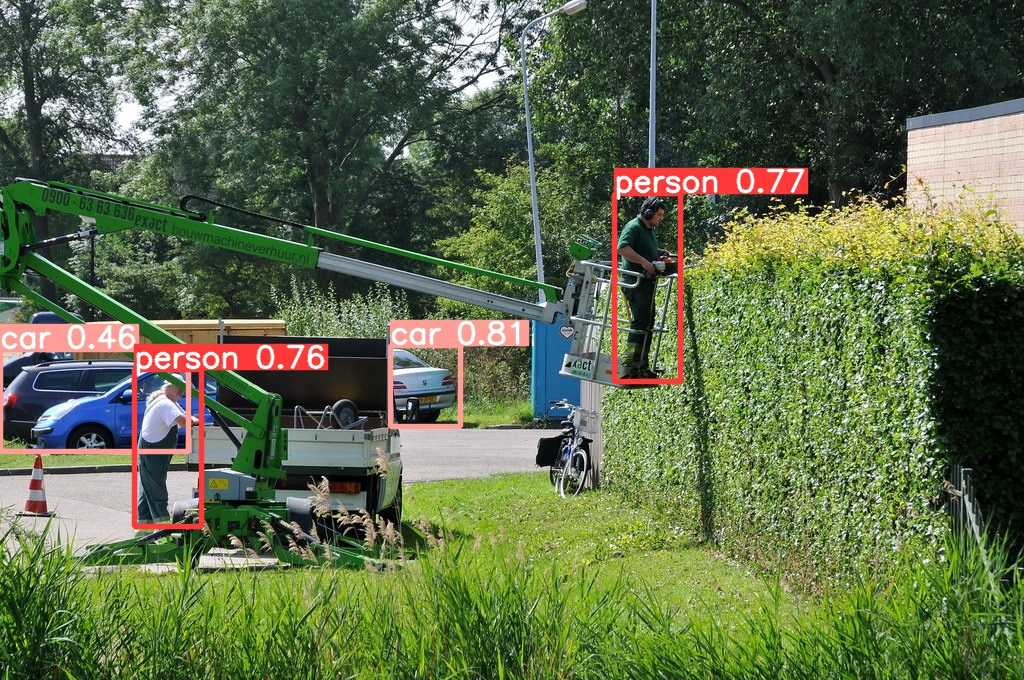

In [12]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/image_000000078.jpg')

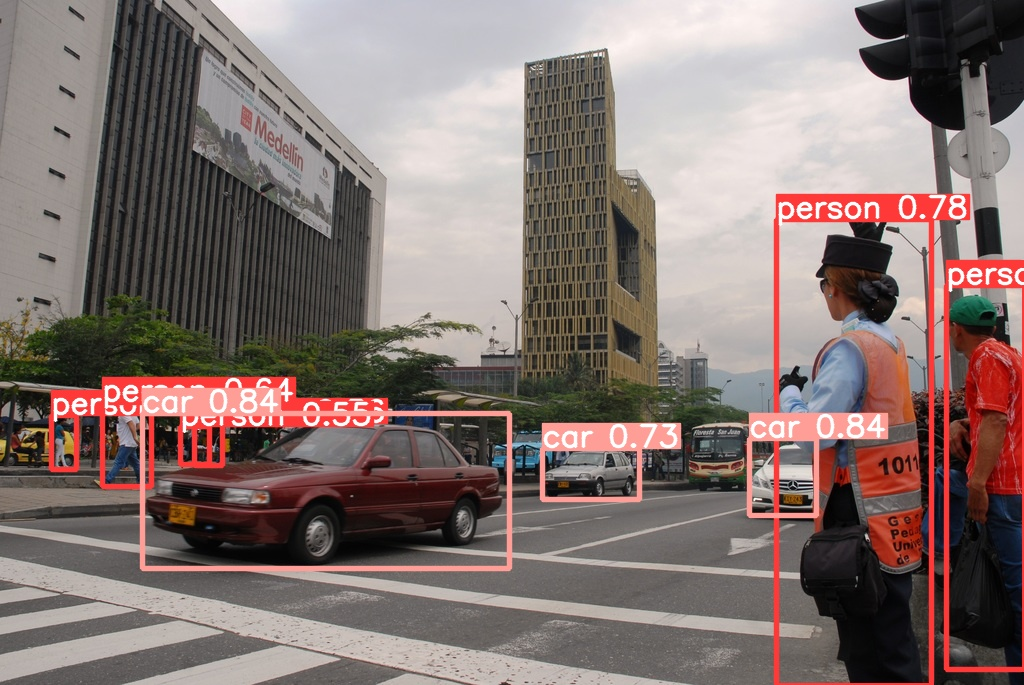

In [14]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/image_000000628.jpg')

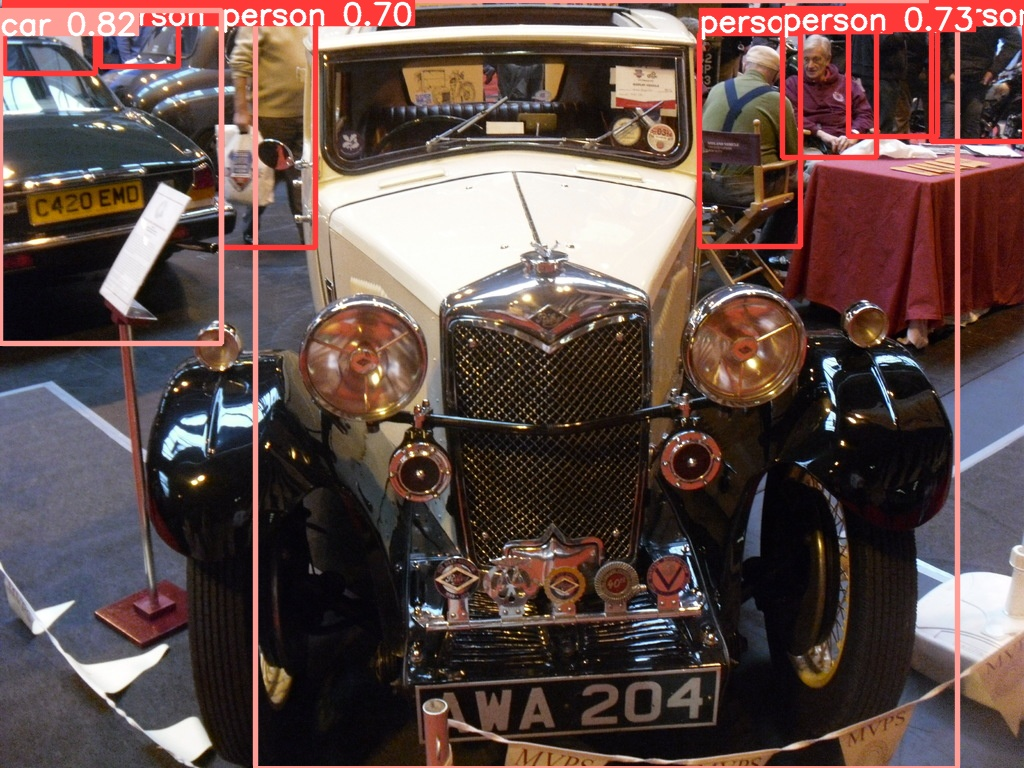

In [17]:
from IPython.display import Image
Image(filename='/content/yolov5/runs/detect/exp/image_000001069.jpg')